Processing object type intrusion set apt intrusion set description suspect fund franistan .. file json1 from file json1
Comparing:
type intrusion set apt intrusion set description suspect fund franistan .. file json1 (file json1)
with
type software word processor description software application create edit text document .. file json1 (file json1)
Similarity: 0.7705256938934326, Threshold: 0.95
Comparing:
type intrusion set apt intrusion set description suspect fund franistan .. file json1 (file json1)
with
type device smartphone description handheld device combine mobile phone computing function .. file json1 (file json1)
Similarity: 0.8639357686042786, Threshold: 0.95
Comparing:
type intrusion set apt intrusion set description suspect fund franistan .. file json1 (file json1)
with
type organization tech corp description company specialize technology software development .. file json1 (file json1)
Similarity: 0.886566698551178, Threshold: 0.95
Comparing:
type intrusion set apt intrusi

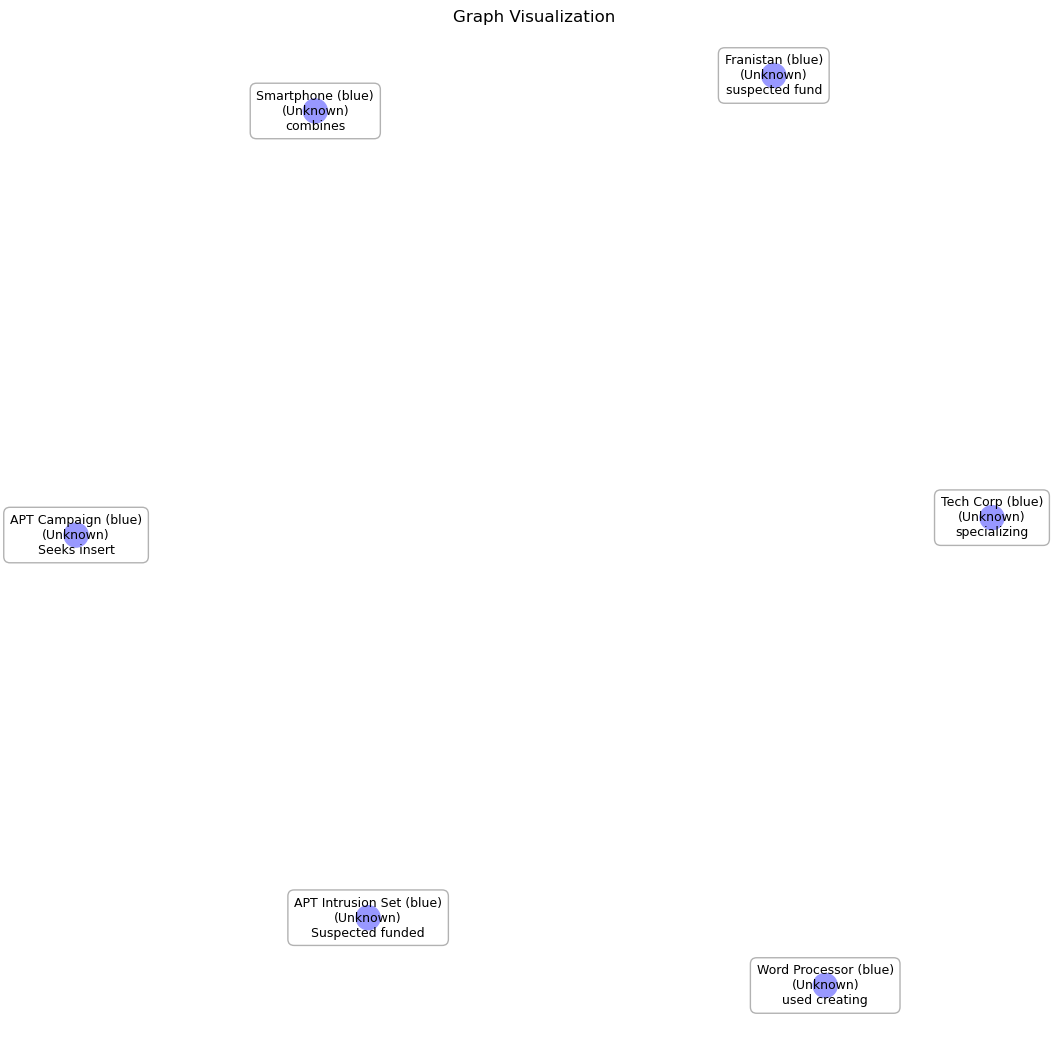

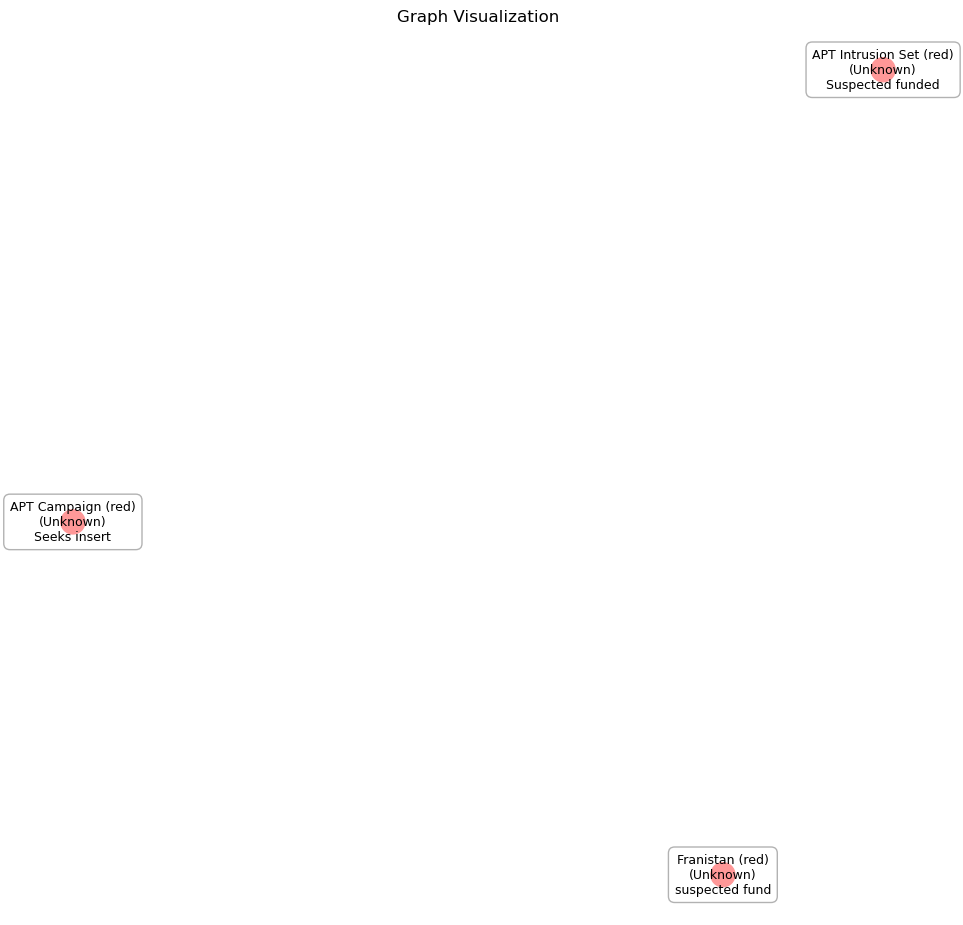

Added node: type intrusion set apt intrusion set description suspect fund franistan .. file json1_blue with name: APT Intrusion Set (blue)
Added node: type software word processor description software application create edit text document .. file json1_blue with name: Word Processor (blue)
Added node: type device smartphone description handheld device combine mobile phone computing function .. file json1_blue with name: Smartphone (blue)
Added node: type organization tech corp description company specialize technology software development .. file json1_blue with name: Tech Corp (blue)
Skipped non-entity node with id: type relationship relationship_type develop source_ref software--1 target_ref organization--3 file json1
Skipped non-entity node with id: type relationship relationship_type source_ref device--2 target_ref software--1 file json1
Added node: type campaign apt campaign description seek insert false information .. file json1_blue with name: APT Campaign (blue)
Added node: typ

In [47]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import string

# Load the spaCy NLP model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    """Preprocess text by lowercasing, removing punctuation, and lemmatization."""
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.text not in string.punctuation and not token.is_stop]
    return ' '.join(tokens)

def json_to_text(data, file_label):
    """Convert JSON entries to text for analysis and remove 'id' key. Add a 'file' key."""
    texts = []
    json_objects = {}
    for entry in data:
        entry.pop('id', None)  # Remove 'id' key
        entry['file'] = file_label  # Add 'file' key
        text = ". ".join(f"{key}: {value}" if not isinstance(value, list) else f"{key}: " + ", ".join(map(str, value)) for key, value in entry.items())
        text = preprocess_text(text)
        texts.append(text)
        json_objects[text] = entry
    return texts, json_objects

def load_json(file_path):
    """Load JSON data from a file with detailed error handling."""
    try:
        with open(file_path, 'r') as file:
            data = file.read()
            return json.loads(data)
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from file - {file_path}")
        print(f"Error details: {e}")
        print(f"Faulty JSON content:\n{data}")
        return None

def assign_encode_ids(texts1, texts2, json_objects1, json_objects2, threshold):
    """Assign encodeID to similar JSON objects in two datasets, ensuring cross-file matching."""
    combined_texts = texts1 + texts2
    combined_json_objects = {**json_objects1, **json_objects2}

    # Compute similarity matrix for combined texts
    similarity_matrix = cosine_similarity([nlp(text).vector for text in combined_texts])
    encode_id = 1
    encode_id_mapping = {}
    assigned_encode_ids = set()

    for i in range(len(combined_texts)):
        obj1 = combined_json_objects[combined_texts[i]]
        if combined_texts[i] in assigned_encode_ids:
            continue

        print(f"Processing object {combined_texts[i]} from file {obj1['file']}")
        is_assigned = False
        for j in range(len(combined_texts)):
            if i != j and combined_texts[j] not in assigned_encode_ids:
                obj2 = combined_json_objects[combined_texts[j]]
                similarity = similarity_matrix[i, j]

                print(f"Comparing:\n{combined_texts[i]} (file {obj1['file']})\nwith\n{combined_texts[j]} (file {obj2['file']})")
                print(f"Similarity: {similarity}, Threshold: {threshold}")

                if similarity > threshold and obj1['file'] != obj2['file']:
                    print(f"Assigning encodeID {encode_id} to {combined_texts[i]} and {combined_texts[j]}")
                    encode_id_mapping[combined_texts[i]] = encode_id
                    encode_id_mapping[combined_texts[j]] = encode_id
                    assigned_encode_ids.add(combined_texts[i])
                    assigned_encode_ids.add(combined_texts[j])
                    encode_id += 1
                    is_assigned = True
                    break

        if not is_assigned:
            encode_id_mapping[combined_texts[i]] = 9999
            assigned_encode_ids.add(combined_texts[i])
            print(f"Assigning encodeID 9999 to {combined_texts[i]}")

    for text, obj in combined_json_objects.items():
        if text in encode_id_mapping:
            obj['encodeID'] = encode_id_mapping[text]

    json_objects1 = {text: obj for text, obj in combined_json_objects.items() if obj['file'] == 'json1'}
    json_objects2 = {text: obj for text, obj in combined_json_objects.items() if obj['file'] == 'json2'}

    return json_objects1, json_objects2

def save_json(data, file_path):
    """Save JSON data to a file."""
    with open(file_path, 'w') as file:
        json.dump(list(data.values()), file, indent=4)

def build_graph(json_objects, suffix, color):
    """Build a graph based on JSON objects."""
    G = nx.Graph()
    valid_nodes = set()

    # Add nodes, ensuring unique IDs
    for key, obj in json_objects.items():
        if obj['type'] != 'relationship':  # Only add entities as nodes
            if obj.get('name') != 'Unknown Name':  # Avoid adding unknown name nodes
                unique_id = key + suffix
                node_name = f"{obj.get('name', 'Unknown Entity')} ({color})"
                G.add_node(unique_id, label=node_name, color=color,
                           description=obj.get('description', 'No description provided'))
                valid_nodes.add(unique_id)
                print(f"Added node: {unique_id} with name: {node_name}")
            else:
                print(f"Filtered out node with id: {key} due to 'Unknown Name'")
        else:
            print(f"Skipped non-entity node with id: {key}")

    # Add edges, using unique IDs
    unique_edges = set()
    for obj in json_objects.values():
        if obj['type'] == 'relationship':
            source = obj.get('source_ref', obj.get('start_node')) + suffix
            target = obj.get('target_ref', obj.get('end_node')) + suffix
            edge = (source, target)
            if source in valid_nodes and target in valid_nodes and source != target:  # Ensure both nodes are valid and not the same
                if edge in unique_edges:
                    G[source][target]['style'] = 'solid'
                    G[source][target]['color'] = 'black'
                else:
                    G.add_edge(source, target, style='dotted', color=color, label=obj.get('relationship_type', 'similar-to'))
                    unique_edges.add(edge)
                print(f"Added edge: {source} -> {target}")
            else:
                print(f"Filtered out edge from {source} to {target} due to invalid nodes")

    return G

def get_optimal_figsize(num_nodes):
    """Determine an optimal figure size based on the number of nodes."""
    base_size = 10  # Base size for the figure
    scale_factor = 0.5  # Scale factor to adjust size
    return (base_size + num_nodes * scale_factor, base_size + num_nodes * scale_factor)

def get_optimal_k(num_nodes):
    """Determine an optimal k value for spring_layout based on the number of nodes."""
    base_k = 0.5  # Base k value
    scale_factor = 0.1  # Scale factor to adjust k
    return base_k + num_nodes * scale_factor

def visualize_graph(G):
    """Visualize a networkx graph with enhanced label formatting for readability."""
    num_nodes = len(G.nodes)
    figsize = get_optimal_figsize(num_nodes)
    k = get_optimal_k(num_nodes)

    plt.figure(figsize=figsize)  # Dynamically set figure size
    pos = nx.spring_layout(G, k=k)  # Dynamically set layout parameter

    # Draw nodes with their corresponding colors
    node_colors = [data.get('color', 'grey') for node, data in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)

    # Draw edges with specified styles and colors
    for (u, v, data) in G.edges(data=True):
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            style=data.get('style', 'dotted' if data['color'] == 'gray' else 'solid'),
            edge_color=data.get('color', 'black'),
            width=2
        )

    # Draw edge labels
    edge_labels = {(u, v): data.get('label', 'similar-to') for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Draw labels for nodes
    labels = {}
    for node, data in G.nodes(data=True):
        label = f"{data.get('label', 'Unknown')}\n({data.get('type', 'Unknown')})"
        description = data.get('description', 'No description provided')
        if description:
            doc = nlp(description)
            verbs = [token.text for token in doc if token.pos_ == 'VERB']
            label += f"\n{' '.join(verbs[:2])}"
        labels[node] = label

    for node, label in labels.items():
        x, y = pos[node]
        plt.text(x, y, label, fontsize=9, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='gray', alpha=0.6))

    plt.title('Graph Visualization')
    plt.axis('off')
    plt.show()

def calculate_distances(json_objects1, json_objects2):
    """Calculate node distance, key distance, value distance, and graph distance."""
    def jaccard_distance(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return 1 - intersection / union if union != 0 else 1

    def set_distance(set1, set2):
        return abs(len(set1) - len(set2))

    # Node distance
    nodes1 = set(json_objects1.keys())
    nodes2 = set(json_objects2.keys())
    node_distance = set_distance(nodes1, nodes2)
    node_jaccard = jaccard_distance(nodes1, nodes2)

    # Key distance
    keys1 = set(k for obj in json_objects1.values() for k in obj.keys())
    keys2 = set(k for obj in json_objects2.values() for k in obj.keys())
    key_distance = set_distance(keys1, keys2)
    key_jaccard = jaccard_distance(keys1, keys2)

    # Value distance
    values1 = set(v for obj in json_objects1.values() for v in obj.values() if isinstance(v, str))
    values2 = set(v for obj in json_objects2.values() for v in obj.values() if isinstance(v, str))
    value_distance = set_distance(values1, values2)
    value_jaccard = jaccard_distance(values1, values2)

    # Graph distance (using node and edge comparison)
    G1 = build_graph(json_objects1, '_blue', 'blue')
    G2 = build_graph(json_objects2, '_red', 'red')
    graph_distance = abs(G1.number_of_nodes() - G2.number_of_nodes()) + abs(G1.number_of_edges() - G2.number_of_edges())
    graph_jaccard = jaccard_distance(set(G1.edges()), set(G2.edges()))

    print(f"Node Distance (Simple): {node_distance}")
    print(f"Node Distance (Jaccard): {node_jaccard:.2f}")
    print(f"Key Distance (Simple): {key_distance}")
    print(f"Key Distance (Jaccard): {key_jaccard:.2f}")
    print(f"Value Distance (Simple): {value_distance}")
    print(f"Value Distance (Jaccard): {value_jaccard:.2f}")
    print(f"Graph Distance (Simple): {graph_distance}")
    print(f"Graph Distance (Jaccard): {graph_jaccard:.2f}")

def main():
    path1 = input("Enter the file path for JSON 1: ").strip('"')
    path2 = input("Enter the file path for JSON 2: ").strip('"')

    data1 = load_json(path1)
    if data1 is None:
        return

    data2 = load_json(path2)
    if data2 is None:
        return

    texts1, json_objects1 = json_to_text(data1, 'json1')
    texts2, json_objects2 = json_to_text(data2, 'json2')

    # Dynamic threshold based on user input or default
    threshold = float(input("Enter the similarity threshold (e.g., 0.8): ").strip())

    json_objects1, json_objects2 = assign_encode_ids(texts1, texts2, json_objects1, json_objects2, threshold)

    # Save normalized JSON data to files for evaluation
    save_json(json_objects1, 'normalized_data1.json')
    save_json(json_objects2, 'normalized_data2.json')

    # Build separate graphs for each JSON dataset
    G1 = build_graph(json_objects1, '_blue', 'blue')
    G2 = build_graph(json_objects2, '_red', 'red')

    visualize_graph(G1)
    visualize_graph(G2)

    # Calculate and print distances
    calculate_distances(json_objects1, json_objects2)

if __name__ == "__main__":
    main()
